<a href="https://colab.research.google.com/github/Adithya018/CYBER-BULLYING-TWEET-PREDICTION/blob/main/Cyberbullying_tweet_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
import seaborn as sns
from sklearn.svm import SVC,LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# stopwords module
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [8]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [9]:
stopwords_list=nltk.corpus.stopwords.words('english')

In [10]:
#loading the data
tweets = pd.read_csv('/content/drive/MyDrive/cyberbullying_tweets.csv')

In [11]:
#sample view of the data
tweets.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [12]:
#overview dataset
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          47692 non-null  object
 1   cyberbullying_type  47692 non-null  object
dtypes: object(2)
memory usage: 745.3+ KB


There are 47k records in the dataset  
There are no null values in the dataset

In [13]:
#statistical analysis of dataset
tweets.describe()

,tweet_text,cyberbullying_type
count,47692,47692
unique,46017,6
top,RT @sailorhg: the intro for my hardware hackin...,religion
freq,2,7998


There are 46017 unique values and 1675 duplicate values

In [14]:
#dropping the duplicates
tweets.drop_duplicates(keep='first',inplace=True)

In [15]:
# type of categories
classes= tweets['cyberbullying_type'].unique()
print('lenght of categories:',len(tweets.columns))
print('classes:',classes)

lenght of categories: 2
classes: ['not_cyberbullying' 'gender' 'religion' 'other_cyberbullying' 'age'
 'ethnicity']


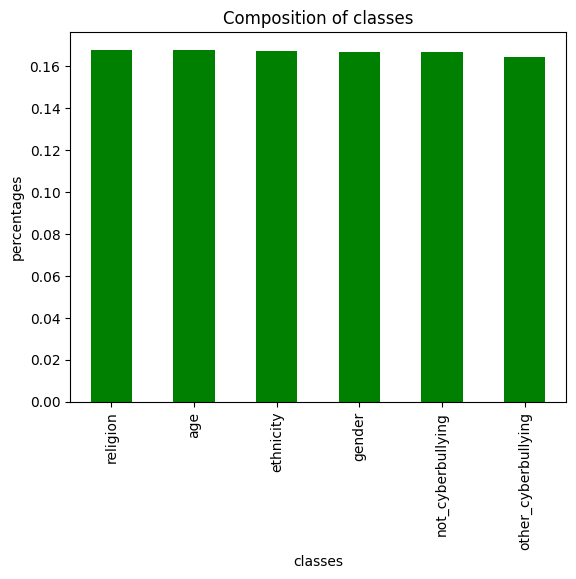

In [16]:
#classes distribution
tweets['cyberbullying_type'].value_counts(normalize=True).plot(kind='bar',color='green')
plt.title('Composition of classes')
plt.xlabel('classes')
plt.ylabel('percentages')
plt.show()

Dataset has balanced classes

In [17]:
#renaming the columns
tweets = tweets.rename(columns={'tweet_text':'text','cyberbullying_type':'type'})

In [18]:
#sample of different categories of bullying
tweets.type.unique()

array(['not_cyberbullying', 'gender', 'religion', 'other_cyberbullying',
       'age', 'ethnicity'], dtype=object)

In [19]:
#sample tweets 
#gender
tweets[tweets.type=='gender'].values[:3]

array([['rape is real..zvasiyana nema jokes about being drunk or being gay or being lesbian...rape is not ones choice or wish..thtz where the sensitivity is coming from',
        'gender'],
       ["You never saw any celebrity say anything like this for Obama: B Maher Incest Rape 'Joke' S Colbert Gay 'joke' K Griffin beheading 'joke'",
        'gender'],
       ["@ManhattaKnight I mean he's gay, but he uses gendered slurs and makes rape jokes",
        'gender']], dtype=object)

In [20]:
#religion
tweets[tweets.type=='religion'].values[5:8]

array([['Urban naxal and a jihadi TT gang put together..wen more than 95% ot the population are happy to be united as one nation inspite of their diversity...who the F are u to preach otherwise..ur just a petty muslim activist...or should i say ground operative for Islamic Terrorism',
        'religion'],
       ['@OneLegSandpiper @DblBlackDs So what is to blame for the more than 100 Islamist terrorists organizations? The Book of Mormon?',
        'religion'],
       ["It's not bjp, it's about you guys always support bad Muslims which makes you bad too, stop supporting those idiots..Hindus never do that..!!",
        'religion']], dtype=object)

In [21]:
#non-bullying
tweets[tweets.type=='not_cyberbullying'].values[:3]

array([['In other words #katandandre, your food was crapilicious! #mkr',
        'not_cyberbullying'],
       ['Why is #aussietv so white? #MKR #theblock #ImACelebrityAU #today #sunrise #studio10 #Neighbours #WonderlandTen #etc',
        'not_cyberbullying'],
       ['@XochitlSuckkks a classy whore? Or more red velvet cupcakes?',
        'not_cyberbullying']], dtype=object)

## Text analysis

## Text preprocessing

In [22]:
# Clean the data
def text_preprocess(text):
    # Remove HTML tags
    text = re.sub('<.*?>', '', text)
    
    # Remove non-alphabetic characters and convert to lowercase
    text = re.sub('[^a-zA-Z]', ' ', text).lower()
    
    # Remove URLs, mentions, and hashtags from the text
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'@\S+', '', text)
    text = re.sub(r'#\S+', '', text)
    
    # Tokenize the text
    words = nltk.word_tokenize(text)
    # print(words)
    # Remove stopwords
    words = [w for w in words if w not in stopwords_list]
    
    # Stem the words
    stemmer = PorterStemmer()
    words = [stemmer.stem(w) for w in words]
    # #lemmatization
    # lemmatizer = WordNetLemmatizer()
    # words = [lemmatizer.lemmatize(w) for w in words]
    
    # Join the words back into a string
    text = ' '.join(words)
    return text

In [23]:
#applying text preprocessing on text column
tweets['text'] = tweets['text'].apply(text_preprocess)

In [24]:
tweets['text'].values[:3]

array(['word katandandr food crapilici mkr',
       'aussietv white mkr theblock imacelebrityau today sunris studio neighbour wonderlandten etc',
       'xochitlsuckkk classi whore red velvet cupcak'], dtype=object)

In [25]:
#label encoding the targets
# label_encoder object knows how to understand word labels.
label_encoder = LabelEncoder()
  
# Encode labels in column 'species'.
tweets['type']= label_encoder.fit_transform(tweets['type'])

In [26]:
#seperating features and targets
X = tweets['text']
y = tweets['type']

In [27]:
#train and test split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2)

In [28]:
#Tfidf vectorizer
term_idf = TfidfVectorizer(min_df=0,max_df=1,use_idf=True,ngram_range=(1,2),max_features=5000)
#transformed train reviews
term_idf_train = term_idf.fit_transform(X_train)
#transformed test reviews
term_idf_test = term_idf.transform(X_test)
print('Tfidf_train:',term_idf_train.shape)
print('Tfidf_test:',term_idf_test.shape)

Tfidf_train: (38124, 5000)
Tfidf_test: (9532, 5000)


In [29]:
#countvectorizer
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
#transformed train reviews
count_vect_train = count_vect.fit_transform(X_train)
#transformed test reviews
count_vect_test = count_vect.transform(X_test)
print('Tfidf_train:',count_vect_train.shape)
print('Tfidf_test:',count_vect_test.shape)

Tfidf_train: (38124, 41211)
Tfidf_test: (9532, 41211)


## Machine learning models

##SVM

In [30]:
from sklearn.svm import SVC
svm_model_linear = SVC(kernel= 'rbf',C=1).fit(count_vect_train, y_train)

In [31]:

svm_predictions  = svm_model_linear.predict(count_vect_test)
svm_accuracy = svm_model_linear.score(count_vect_test, y_test)

In [32]:
svm_accuracy

0.8409567771716324

In [33]:
from sklearn.metrics import classification_report

In [34]:
#classification report
print(classification_report(y_test,svm_predictions))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1597
           1       0.99      0.98      0.99      1607
           2       0.90      0.83      0.87      1531
           3       0.69      0.48      0.57      1625
           4       0.58      0.83      0.69      1546
           5       0.95      0.94      0.95      1626

    accuracy                           0.84      9532
   macro avg       0.85      0.84      0.84      9532
weighted avg       0.85      0.84      0.84      9532



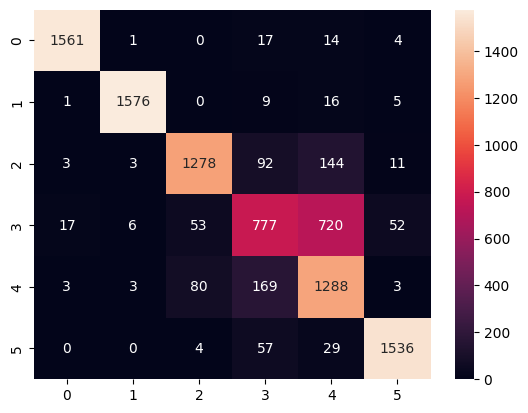

In [35]:
#confusion matrix
cm = confusion_matrix(y_test,svm_predictions)
sns.heatmap(cm,annot=True,fmt='g')
plt.show()

##Multinomial Naive Bayes

In [36]:
mnb = MultinomialNB(force_alpha=True,fit_prior=True)
mnb.fit(count_vect_train, y_train)

MultinomialNB(force_alpha=True)

In [37]:
mnb_predictions  = mnb.predict(count_vect_test)
mnb_accuracy = mnb.score(count_vect_test, y_test)

In [38]:
mnb_accuracy

0.7783256399496433

In [39]:
print(classification_report(y_test,mnb_predictions))

              precision    recall  f1-score   support

           0       0.75      0.99      0.85      1597
           1       0.86      0.95      0.90      1607
           2       0.82      0.83      0.83      1531
           3       0.69      0.41      0.51      1625
           4       0.65      0.52      0.58      1546
           5       0.83      0.97      0.90      1626

    accuracy                           0.78      9532
   macro avg       0.77      0.78      0.76      9532
weighted avg       0.77      0.78      0.76      9532



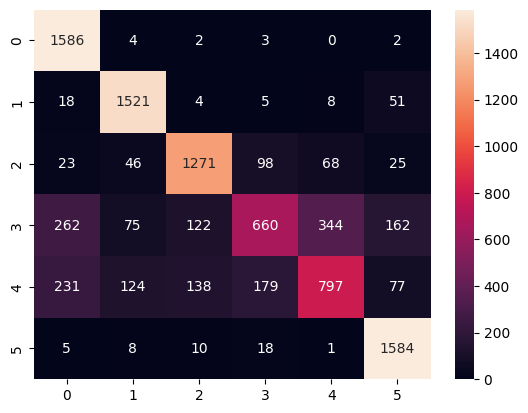

In [40]:
cm = confusion_matrix(y_test,mnb_predictions)
sns.heatmap(cm,annot=True,fmt='g')
plt.show()

## Logistic regression

In [41]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

In [42]:
lr.fit(count_vect_train, y_train)

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [43]:
lr_predictions  = lr.predict(count_vect_test)
accuracy = lr.score(count_vect_test, y_test)

In [44]:
print(classification_report(y_test,lr_predictions))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      1597
           1       0.99      0.98      0.98      1607
           2       0.90      0.84      0.87      1531
           3       0.59      0.57      0.58      1625
           4       0.59      0.66      0.62      1546
           5       0.96      0.95      0.95      1626

    accuracy                           0.83      9532
   macro avg       0.83      0.83      0.83      9532
weighted avg       0.83      0.83      0.83      9532



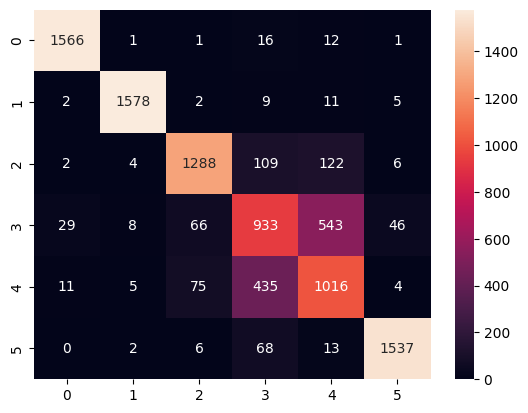

In [45]:
cm = confusion_matrix(y_test,lr_predictions)
sns.heatmap(cm,annot=True,fmt='g')
plt.show()

## RandomForestClassifier

In [46]:
from sklearn.ensemble import RandomForestClassifier

In [47]:
rf = RandomForestClassifier()
rf.fit(count_vect_train, y_train)

RandomForestClassifier()

In [48]:
rf_predictions  = rf.predict(count_vect_test)
accuracy_rf = rf.score(count_vect_test, y_test)

In [49]:
accuracy_rf

0.8220730172052035

In [50]:
print(classification_report(y_test,rf_predictions))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97      1597
           1       0.99      0.99      0.99      1607
           2       0.89      0.83      0.86      1531
           3       0.60      0.48      0.53      1625
           4       0.55      0.69      0.61      1546
           5       0.95      0.96      0.95      1626

    accuracy                           0.82      9532
   macro avg       0.82      0.82      0.82      9532
weighted avg       0.83      0.82      0.82      9532



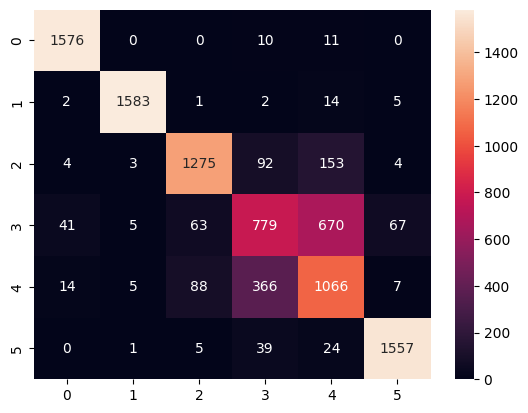

In [51]:
cm = confusion_matrix(y_test,rf_predictions)
sns.heatmap(cm,annot=True,fmt='g')
plt.show()

In [52]:
#results analysis
model_accu = [['SVM', 10], ['LogisticRegression', 15], ['RandomForest', 14],['MultinomialNaiveBayes',]]
pd.DataFrame()

""
